In [54]:
import pickle
import scipy
import numpy as np
import astropy.units as u
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy import optimize
from astropy.timeseries import LombScargle
from lc_download_methods import diff_image_lc_download
from remove_tess_systematics import clean_tess_lc
plt.ion()

In [81]:
def trig_func(t,f,a,b,c):
    return a*np.sin(2*np.pi*f*t) + b*np.cos(2*np.pi*f*t) + c

def next_highest_freq(time, flux, freq, f_remove, plot_ls_fig = False):
    popt_maxV, pcov_maxV = optimize.curve_fit(lambda t, a, b, c: trig_func(t,f_remove, a, b, c), time, flux, maxfev=1000)
    max_var = trig_func(time,f_remove,*popt_maxV)
    flux = flux/max_var
    power = LombScargle(time, flux).power(freq)
    if plot_ls_fig == True:
        ls_fig = plt.figure()
        plt.plot(freq, power, c='k', linewidth = 1)
        plt.xlabel('Frequency')
        plt.ylabel('Power')
        plt.title('{} LombScargle Periodogram'.format(target_ID))
        ls_fig.show()
    i = np.argmax(power)
    freq_2 = freq[i]
    return freq_2, flux

def find_freqs(time, flux, plot_ls_fig = True):
    
    # Remove frequencies associated with 14d data gap
    f=1/14
    popt_sys, pcov_sys = optimize.curve_fit(lambda t, a, b, c: trig_func(t,f, a, b, c), time, flux, maxfev=1000)
    sys_var = trig_func(time,f,*popt_sys)
    flux = flux/sys_var
    
     #From Lomb-Scargle
    freq = np.arange(0.05,4.1,0.00001)
    power = LombScargle(time, flux).power(freq)
    if plot_ls_fig == True:
        ls_fig = plt.figure()
        plt.plot(freq, power, c='k', linewidth = 1)
        plt.xlabel('Frequency')
        plt.ylabel('Power')
        plt.title('{} LombScargle Periodogram for original lc'.format(target_ID))
        ls_fig.show()
#        ls_fig.savefig(save_path + '{} - Lomb-Scargle Periodogram for original lc.png'.format(target_ID))
#        plt.close(ls_fig)
    i = np.argmax(power)
    freq_rot = freq[i]
    
    # Remove highest frequency to get 2nd highest
    f_remove=freq_rot
    freq_2, flux = next_highest_freq(time, flux, freq, f_remove, plot_ls_fig = False)
        
    # Remove 2nd highest frequency to get 3rd highest
    f_remove=freq_2
    freq_3, flux = next_highest_freq(time, flux, freq, f_remove, plot_ls_fig = False)

    freq_list = [freq_rot,freq_2,freq_3]
    
    #final_fig = plt.figure()
    #plt.scatter(time,flux,s=1,c='k')
    #plt.show()
    
    return freq_list

/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Part 1: Importing Light-curve:

In [77]:
target_ID = 'HD 33512'
sector = 5
lc, filename = diff_image_lc_download(target_ID, sector, plot_lc=False)
clean_time, clean_flux, clean_flux_err = clean_tess_lc(lc.time, lc.flux, lc.flux_err, target_ID, sector, save_path='')
time = clean_time
flux = clean_flux

/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Trying file 14091633_sector05_3_1.lc
Got the light-curve out


# Part 2: Initial LS and removal of 14-day orbit systematic

<IPython.core.display.Javascript object>


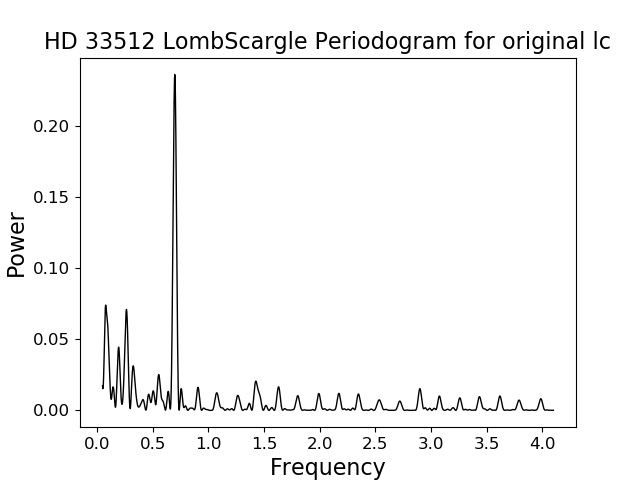

Max frequencies = [0.6989800000001988, 0.07825000000000865, 0.2645700000000657]
[-6.43807761e-04  2.01461145e-05  1.00014253e+00]


<IPython.core.display.Javascript object>


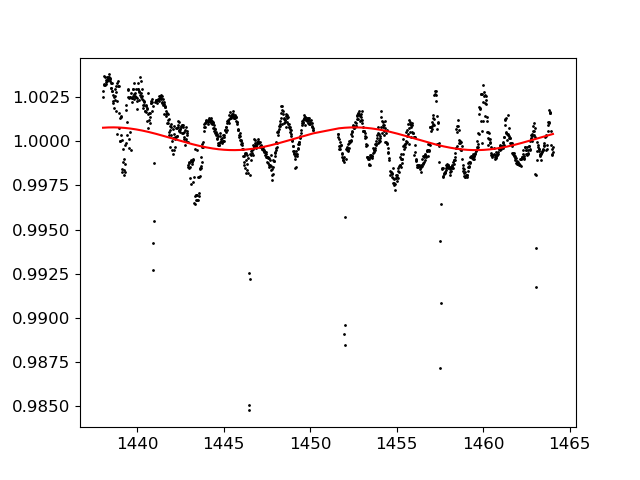

In [57]:
freq_list = find_freqs(time,flux,plot_ls_fig = True)
print('Max frequencies = {}'.format(freq_list))

def trig_func(t,f,a,b,c):
    return a*np.sin(2*np.pi*f*t) + b*np.cos(2*np.pi*f*t) + c

f=1/14

popt, pcov = optimize.curve_fit(lambda t, a, b, c: trig_func(t,f, a, b, c), time, flux, maxfev=1000)
#params, params_covariance = optimize.curve_fit(trig_func, time, flux)
print(popt)

plt.figure()
plt.plot(time, trig_func(time,f,*popt), 'r-')
plt.scatter(time,flux,s=1,c='k')

# Part 3: Finding and removing max variability period

/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


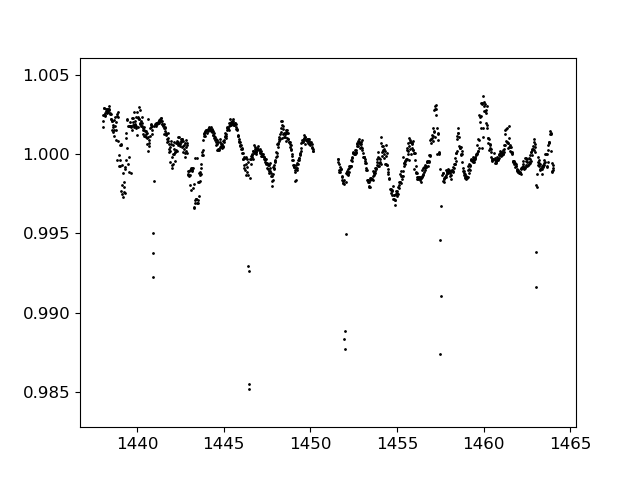

In [58]:
max_var = trig_func(time,f,*popt)

new_flux = flux/max_var

plt.figure()
plt.scatter(time, new_flux, s=1, c='k')

<IPython.core.display.Javascript object>


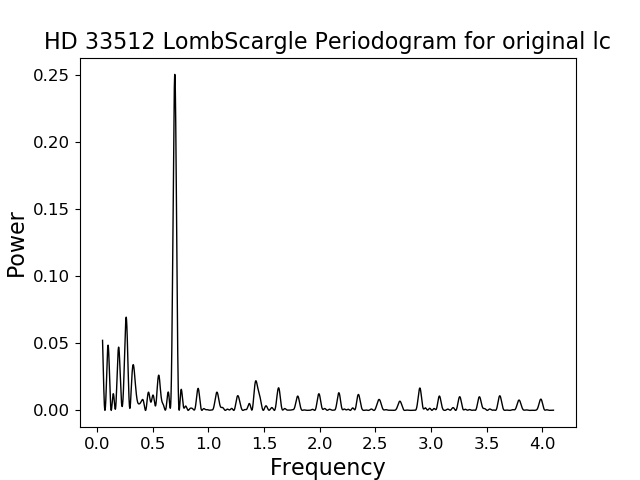

Final Max frequencies = [0.6989600000001988, 0.26203000000006493, 0.09946000000001515]
[ 5.79188612e-04 -1.06596508e-03  9.99996128e-01]


<IPython.core.display.Javascript object>


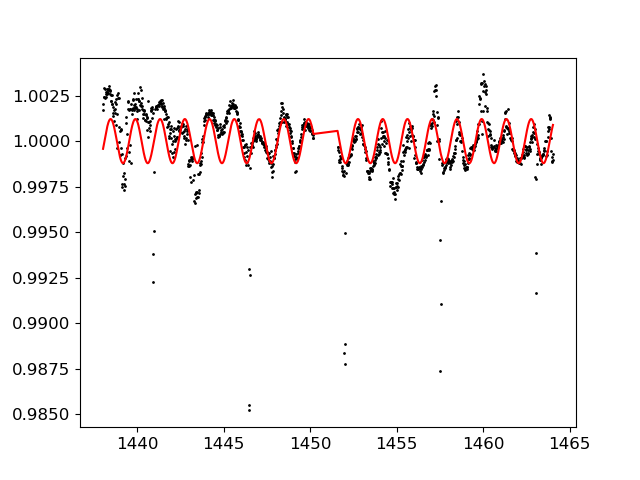

In [59]:
freq_list = find_freqs(time,new_flux,plot_ls_fig = True)
print('Final Max frequencies = {}'.format(freq_list))

f=freq_list[0]

popt, pcov = optimize.curve_fit(lambda t, a, b, c: trig_func(t,f, a, b, c), time, new_flux, maxfev=1000)
#params, params_covariance = optimize.curve_fit(trig_func, time, flux)
print(popt)

plt.figure()
plt.plot(time, trig_func(time,f,*popt), 'r-')
plt.scatter(time,new_flux,s=1,c='k')

/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


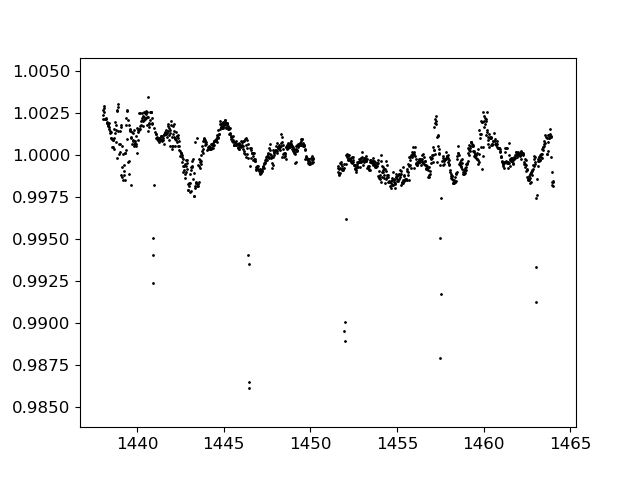

In [60]:
max_var = trig_func(time,f,*popt)

new_flux = new_flux/max_var

plt.figure()
plt.scatter(time, new_flux, s=1, c='k')

## Part 4: Finding remaining two highest periods 

<IPython.core.display.Javascript object>


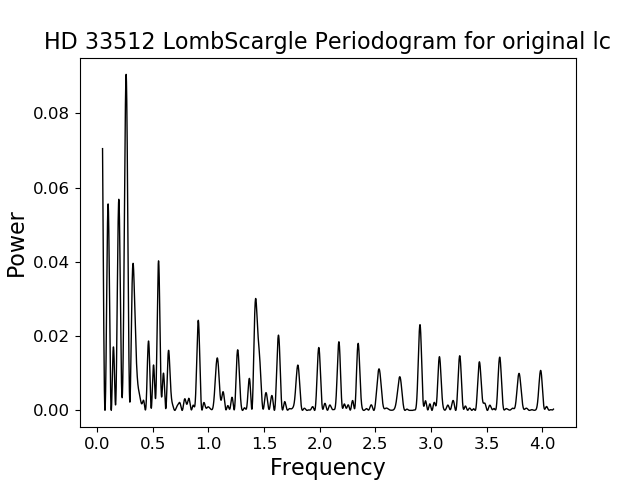

Final Max frequencies = [0.2616800000000648, 0.19624000000004477, 0.09978000000001525]


In [61]:
freq_list_2 = find_freqs(time,new_flux,plot_ls_fig = True)
print('Final Max frequencies = {}'.format(freq_list_2))

## Appendix: trying all at once using find_freqs

<IPython.core.display.Javascript object>


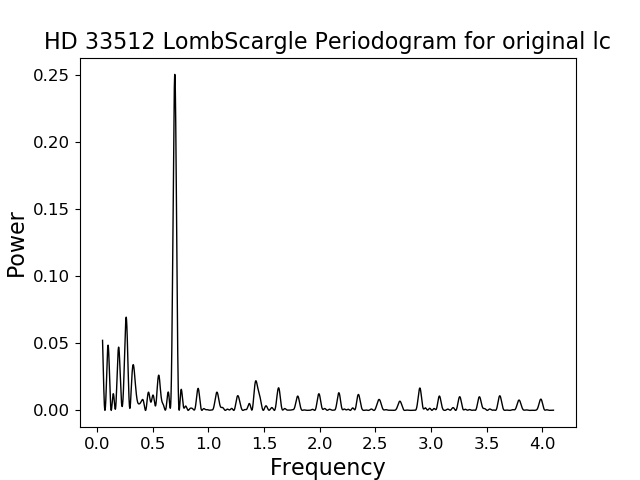

[0.6989600000001988, 0.2616800000000648, 0.05]
[1.4306970355953355, 3.8214613268104265, 20.0]


In [82]:
overall_freq_list = find_freqs(time,flux,plot_ls_fig = True)
print(overall_freq_list)
periods = [1/item for item in overall_freq_list]
print(periods)